In [1]:
import os
import matplotlib.pyplot as plt
import threedhst.eazyPy as eazy
import numpy as np
import astropy.io.fits as pyfits
from scipy import interpolate
from astropy.cosmology import FlatLambdaCDM

import matplotlib.pyplot as plt
%pylab inline

#plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':64})
## for Palatino and other serif fonts use:
plt.rc('font',**{'family':'serif','size':14})
plt.rc('text', usetex=True)


 but the reduction scripts should be OK.

Populating the interactive namespace from numpy and matplotlib


In [2]:
def read_filters(files, lam, base):
    # make array
    filt_array = np.empty([len(files),len(lam)], dtype=float)
    i = 0
    # read each filter
    for ffilt in files:
        lam_tmp = []
        resp_tmp = []
        print(ffilt)
        for line in open(base+ffilt, 'r'):
            if line[0] != '#':
                lam_tmp.append(line.split()[0])
                resp_tmp.append(line.split()[1])
        lam_tmp = np.array(lam_tmp, dtype=float)
        resp_tmp = np.array(resp_tmp, dtype=float)
        # put templates / filters on the common grid (lam)
        f = interpolate.interp1d(lam_tmp, resp_tmp, bounds_error=False, fill_value=0)
        filt_array[i,:] = f(lam)
        i += 1
    return filt_array

# integrate filter over template
def int_filter(filters, flux):
    flux_int = []
    for i in range(filters.shape[0]):
        flux_int.append(np.sum(filters[i,:]*flux)/np.sum(filters[i,:]))
    return np.array(flux_int)


def chisq(filters, wave, sed, flux, ferr, z=0):
    sed = interpolate.interp1d(wave*(1+z), sed, bounds_error=False, fill_value=0)(wave)
    sed_flux = int_filter(filters, sed)
    a = np.sum(flux*sed_flux/(ferr*ferr)) / np.sum(sed_flux*sed_flux/(ferr*ferr))
    siga = ((ferr*sed_flux/(ferr*ferr)) / np.sum(sed_flux*sed_flux/(ferr*ferr)))**2
    siga = np.sqrt(np.sum(siga))
    return np.sum((a*sed_flux-flux)**2/(ferr*ferr)), a, siga, sed_flux


In [3]:
cosmo = FlatLambdaCDM(Om0=0.3, H0=70)

In [4]:
kcorr = pyfits.open("k_nmf_derived.default_fromskypy.fits")

seds = kcorr[1].data
kcorr_wave = kcorr[11].data
print(kcorr[16].data)
print(kcorr[17].data)
print(seds.shape)

[1. 1. 1. 1. 1.]
[0.60152453 0.94151086 0.60703266 0.5237318  0.7639372 ]
(5, 10000)


In [5]:
# change seds from erg/s/cm^2/A to uJy
# lambda^2 / c * 1e29
for i in range(5):
    seds[i,:] = seds[i,:] * ((kcorr_wave*kcorr_wave*1e-10)/2.99e8) * 1e29

In [6]:
print(seds)
print(5500*5500/(2.99e8*1e10)*1e29)

[[2.5605576e+02 2.5501173e+02 2.5359610e+02 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [3.1231590e+08 3.1325299e+08 3.1452288e+08 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [7.7992690e+03 7.7798711e+03 7.7535640e+03 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [3.8588132e+03 3.8438687e+03 3.8236045e+03 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [6.7201680e+03 6.7159858e+03 6.7103066e+03 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]
1.011705685618729e+18


In [7]:
amps = np.array([7.8800161e-12, 5.0557465e-09, 8.0048974e-11, 1.0215842e-11, 1.3721980e-10])

In [8]:
cat = pyfits.open("COSMOS2020_Classic_processed.fits")[1].data
coeff = pyfits.open("cosmos2020_kcorr_coeffs.fits")[1].data

In [9]:
cat

FITS_rec([( 201293, 150.75333206, 1.60333326,         nan,        nan,        nan,        nan, 1.2724, 0, 1.32, 0.4 , 5, 5.088e+08, 0.2, 1, -16.42532, -17.47112, -17.97332, -17.95175, -18.11549, -17.9356 ,  8.4021 ,  7.98959,  8.79633,  8.27906,  -0.19806,  0.04708582, 0.02442178,  0.04687444, 0.01510858, 2.74320003e-02, 0.01213079, 3.68322432e-02, 0.01683687, 5.57272322e-02, 0.02073867,   0.13992296, 0.03282579, 5.49500287e-02, 0.07188967, -9.11564589e-01, 1.0988934 ,   1.26431143, 0.52871728,  1.02518484e-01, 0.57759637, -2.41558045e-01, 0.33362406,  0.06466766, 0.06754313,  0.27267125, 0.10836231,  0.08009359, 0.0504899 , 2.99152043e-02, 0.0807681 ,  0.10450204, 0.0557193 , 2.28106305e-01, 0.10348302, 5.70354648e-02, 0.05841523,  5.37912473e-02, 0.10134099, 1.30193710e-01, 0.09429541,  0.10302574, 0.08104015,  0.28577948, 0.11419294,  2.16846377e-01, 0.10968234,  0.04300074, 0.01754155, 5.51951230e-02, 0.03398719,  0.07608438, 0.02841315, 6.74428642e-02, 0.04200212,   0.16183953, 0.

In [10]:
# pick a brighter subset to look at
mask = np.where((23.9-2.5*np.log10(cat['UVISTA_Ks_FLUX'])<25.5)&(cat['photoz']>0))[0]

cat = cat[mask]
coeff = coeff[mask]
print(len(cat))

<ipython-input-10-71e41e35c6cd>:2: RuntimeWarning: invalid value encountered in log10
  mask = np.where((23.9-2.5*np.log10(cat['UVISTA_Ks_FLUX'])<25.5)&(cat['photoz']>0))[0]


422127


In [11]:
# Filter names, mean wavelength, and other info (see Table 1 in W+21)
filt_name = np.array(['GALEX_FUV', 'GALEX_NUV','CFHT_u','CFHT_ustar','HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 
                      'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'SC_IB427', 'SC_IB464', 
                      'SC_IA484', 'SC_IB505', 'SC_IA527', 'SC_IB574', 'SC_IA624', 'SC_IA679', 'SC_IB709', 
                      'SC_IA738', 'SC_IA767', 'SC_IB827', 'SC_NB711', 'SC_NB816', 'UVISTA_NB118', 'SC_B', 
                      'SC_gp', 'SC_V', 'SC_rp', 'SC_ip','SC_zp', 'SC_zpp', 'IRAC_CH1', 'IRAC_CH2', 
                      'IRAC_CH3','IRAC_CH4'])  
filt_lambda = 1e4*np.array([0.1526,0.2307,0.3709,0.3858,0.4847,0.6219,0.7699,0.8894,0.9761,1.0216,1.2525,
                            1.6466,2.1557,0.4266,0.4635,0.4851,0.5064,0.5261,0.5766,0.6232,0.6780,0.7073,
                            0.7361,0.7694,0.8243,0.7121,0.8150,1.1909,0.4488,0.4804,0.5487,0.6305,0.7693,
                            0.8978,0.9063,3.5686,4.5067,5.7788,7.9958])


In [12]:
use_filt = np.array([2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,28,30,31,32,34,35,36])
filt_name[use_filt]

array(['CFHT_u', 'CFHT_ustar', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z',
       'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks',
       'SC_IB427', 'SC_IB464', 'SC_IA484', 'SC_IB505', 'SC_IA527',
       'SC_IB574', 'SC_IA624', 'SC_IA679', 'SC_IB709', 'SC_IA738',
       'SC_IA767', 'SC_IB827', 'SC_B', 'SC_V', 'SC_rp', 'SC_ip', 'SC_zpp',
       'IRAC_CH1', 'IRAC_CH2'], dtype='<U12')

In [13]:
W21_phot = np.array([cat["{}_FLUX".format(band)] for band in filt_name[use_filt]]).T
W21_err = np.array([cat["{}_FLUXERR".format(band)] for band in filt_name[use_filt]]).T

# There are some -99's in this cat, that I think should be NaNs
W21_phot[W21_phot==-99.] = np.nan

# restrict lambda to chosen filters
W21_lam = filt_lambda[use_filt]

In [40]:
#ob = 50020
#ob = 5015
ob = 3086
print(cat['photoz'][ob])
print(coeff['coeffs'][ob,:], np.sum(coeff['coeffs'][ob,:]))
print(coeff['coeffs'][ob,:]*amps, np.sum(coeff['coeffs'][ob,:]*amps))

1.3239
[2.5014389e+10 5.1883230e-06 1.2574813e+10 1.1004412e+11 1.3208424e+09] 148954170000.0
[1.97113786e-01 2.62308460e-14 1.00660089e+00 1.12419333e+00
 1.81245726e-01] 2.509153738302556


In [41]:
sed = np.sum(seds.T*coeff['coeffs'][ob,:], axis=1)
wave_mask = np.where((kcorr_wave*(1+cat['photoz'][ob])>3300)&(kcorr_wave*(1+cat['photoz'][ob])<50000))[0]

In [42]:
#chi2, a, _, modf = chisq(filters, wave, sed, flux[:,indx], ferr[:,indx], z=cat['PHOTOZ'][indx])
#print(chi2)

# need to figure out the units.
#a = 1.e11 #/ (1+cat['photoz'][ob])
a = 1./1.011705685618729e+18  #### is this value exactly right??? Where does it come from?
#a = 1e-10 / 2.99e8 # nope, not this....
#a = 2e-10
#a = 1
# plus the 1e29 not included from earlier. -> 1e40 

# Mpc -> cm:  1/3.2407792700054E-25
# scale = ((1+cat['photoz'][ob])*4*np.pi*(cosmo.luminosity_distance(cat['photoz'][ob]).value / 
#                                       3.2407792700054E-25)**2)
scale2 = ((cosmo.luminosity_distance(cat['photoz'][ob]).value*1e5)**2 / (1+cat['photoz'][ob]))
#print(np.log10(scale), np.log10(scale2), np.log10(np.sum(coeff['coeffs'][ob,:])), cat['lp_mass_best'][ob])

# scale2 should be the correct one.
print(np.log10(scale2)+np.log10(np.sum(coeff['coeffs'][ob,:]))-18, cat['lp_mass_best'][ob])

10.748433782878411 10.23098


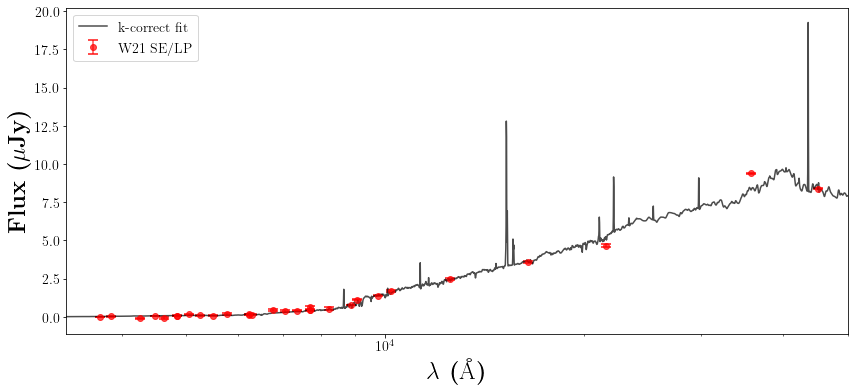

In [43]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r'\textbf{$\lambda$ (${\rm \AA}$)}', fontsize=24)
ax.set_ylabel(r'\textbf{Flux ($\mu$Jy)}', fontsize=24)
ax.set_xscale('log')

ax.errorbar(W21_lam, W21_phot[ob,:], yerr=W21_err[ob,:], marker='o', c='r', 
            label='W21 SE/LP', capthick=2, capsize=5, ls='', alpha=0.7)

ax.plot(kcorr_wave[wave_mask]*(1+cat['photoz'][ob]), sed[wave_mask]*a, 'k-', alpha=0.7, label='k-correct fit')

ax.set_xlim([3300.,50000.])
ax.legend(fontsize=14, loc=2)
plt.show()

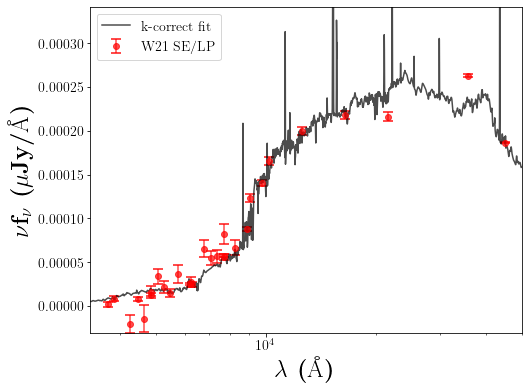

In [56]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r'\textbf{$\lambda$ (${\rm \AA}$)}', fontsize=24)
ax.set_ylabel(r'\textbf{$\nu$f$_{\nu}$ ($\mu$Jy/${\rm \AA}$)}', fontsize=24)
ax.set_xscale('log')
#plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.subplots_adjust(left=0.15)

ax.errorbar(W21_lam, W21_phot[ob,:]/W21_lam, yerr=W21_err[ob,:]/W21_lam, marker='o', c='r', 
            label='W21 SE/LP', capthick=2, capsize=5, ls='', alpha=0.7)

ax.plot(kcorr_wave[wave_mask]*(1+cat['photoz'][ob]), 
        sed[wave_mask]*a/(kcorr_wave[wave_mask]*(1+cat['photoz'][ob])), 
        'k-', alpha=0.7, label='k-correct fit')

ax.set_xlim([3300.,50000.])
ax.set_ylim([np.min(W21_phot[ob,:]/W21_lam)-np.abs(np.min(W21_phot[ob,:]/W21_lam))*0.5, 
             np.max(W21_phot[ob,:]/W21_lam)*1.3])
ax.legend(fontsize=14, loc=2)
plt.savefig("example_SED_fit.png")
plt.show()

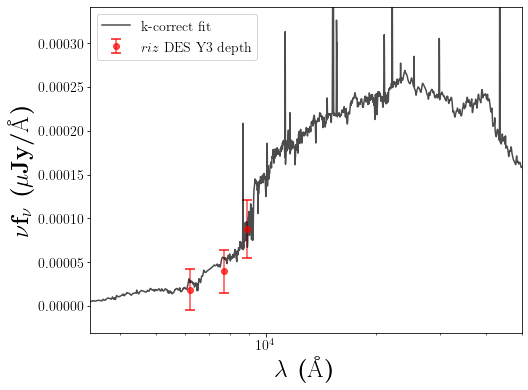

In [78]:
riz = np.array([3,4,5])

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r'\textbf{$\lambda$ (${\rm \AA}$)}', fontsize=24)
ax.set_ylabel(r'\textbf{$\nu$f$_{\nu}$ ($\mu$Jy/${\rm \AA}$)}', fontsize=24)
ax.set_xscale('log')
#plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.subplots_adjust(left=0.15)

df = np.random.normal(0,6.3*W21_err[ob,riz])

ax.errorbar(W21_lam[riz], (W21_phot[ob,riz]+df)/W21_lam[riz], yerr=15*W21_err[ob,riz]/W21_lam[riz], 
            marker='o', c='r', label='$riz$ DES Y3 depth', capthick=2, capsize=5, ls='', alpha=0.7)

ax.plot(kcorr_wave[wave_mask]*(1+cat['photoz'][ob]), 
        sed[wave_mask]*a/(kcorr_wave[wave_mask]*(1+cat['photoz'][ob])), 
        'k-', alpha=0.7, label='k-correct fit')

ax.set_xlim([3300.,50000.])
ax.set_ylim([np.min(W21_phot[ob,:]/W21_lam)-np.abs(np.min(W21_phot[ob,:]/W21_lam))*0.5, 
             np.max(W21_phot[ob,:]/W21_lam)*1.3])
ax.legend(fontsize=14, loc=2)
plt.savefig("example_SED_fit_riz.png")
plt.show()

# compute luminosities

In [19]:
# get the filter
#lum_filt = ["hsc_r2_v2018.dat"]
#passband = read_filters(lum_filt, kcorr_wave, '../inputs/')
passband = np.genfromtxt("../inputs/hsc_r2_v2018.dat",skip_header=1,usecols=[1,2])
print(passband[:,0])
print(np.average(passband[:,0], weights=passband[:,1]))
passband = interpolate.interp1d(passband[:,0], passband[:,1], bounds_error=False, fill_value=0)(kcorr_wave)

[5100. 5110. 5120. 5130. 5140. 5150. 5160. 5170. 5180. 5190. 5200. 5210.
 5220. 5230. 5240. 5250. 5260. 5270. 5280. 5290. 5300. 5310. 5320. 5330.
 5340. 5350. 5360. 5370. 5380. 5390. 5400. 5410. 5420. 5430. 5440. 5450.
 5460. 5470. 5480. 5490. 5500. 5510. 5520. 5530. 5540. 5550. 5560. 5570.
 5580. 5590. 5600. 5610. 5620. 5630. 5640. 5650. 5660. 5670. 5680. 5690.
 5700. 5710. 5720. 5730. 5740. 5750. 5760. 5770. 5780. 5790. 5800. 5810.
 5820. 5830. 5840. 5850. 5860. 5870. 5880. 5890. 5900. 5910. 5920. 5930.
 5940. 5950. 5960. 5970. 5980. 5990. 6000. 6010. 6020. 6030. 6040. 6050.
 6060. 6070. 6080. 6090. 6100. 6110. 6120. 6130. 6140. 6150. 6160. 6170.
 6180. 6190. 6200. 6210. 6220. 6230. 6240. 6250. 6260. 6270. 6280. 6290.
 6300. 6310. 6320. 6330. 6340. 6350. 6360. 6370. 6380. 6390. 6400. 6410.
 6420. 6430. 6440. 6450. 6460. 6470. 6480. 6490. 6500. 6510. 6520. 6530.
 6540. 6550. 6560. 6570. 6580. 6590. 6600. 6610. 6620. 6630. 6640. 6650.
 6660. 6670. 6680. 6690. 6700. 6710. 6720. 6730. 67

In [20]:
# integrate filter over template
def comp_flux(passband, flux, z=0):
    f_tmp = interpolate.interp1d(kcorr_wave, flux, bounds_error=False, fill_value=0)(kcorr_wave/(1+z))
    flux_int = np.sum(passband*f_tmp*kcorr_wave)/np.sum(passband*kcorr_wave)
    return flux_int

# # build flux cube
# zarr = np.arange(0.01,10.01,0.01)
# f_sed = np.zeros((len(zarr),seds.shape[0]))
# for i in range(seds.shape[0]):
#     for j,z in enumerate(zarr):
#         f_sed[j,i] = comp_flux(passband, seds[i,:], z=z)

f_sed = np.array([comp_flux(passband, seds[i,:]) for i in range(seds.shape[0])])

In [21]:
f_sed

array([1.32941182e+07, 5.55562087e+09, 1.01302981e+08, 1.33095381e+07,
       1.48986815e+08])

In [22]:
zscl = np.log10((cosmo.luminosity_distance(cat['photoz']).value*1e5)**2 / (1+cat['photoz']))
#mass = np.log10(np.sum(coeff['coeffs']*amps, axis=1)) # no, this doesn't match the SED.
mass = np.log10(np.sum(coeff['coeffs']*kcorr[17].data, axis=1))
mass_form = np.log10(np.sum(coeff['coeffs'], axis=1))
r_lum = 23.9-2.5*np.log10(np.sum(coeff['coeffs']*f_sed*a, axis=1))-2.5*zscl

offset = np.log10(1/1.011705685618729e+18)
print(1/1.011705685618729e+18)

9.884297520661159e-19


<ipython-input-22-396dd39084ab>:3: RuntimeWarning: divide by zero encountered in log10
  mass = np.log10(np.sum(coeff['coeffs']*kcorr[17].data, axis=1))
<ipython-input-22-396dd39084ab>:4: RuntimeWarning: divide by zero encountered in log10
  mass_form = np.log10(np.sum(coeff['coeffs'], axis=1))
<ipython-input-22-396dd39084ab>:5: RuntimeWarning: divide by zero encountered in log10
  r_lum = 23.9-2.5*np.log10(np.sum(coeff['coeffs']*f_sed*a, axis=1))-2.5*zscl


In [23]:
r_lum

array([-18.54836338, -16.90865805, -18.14063307, ..., -23.11251978,
       -22.01190704, -21.99987175])

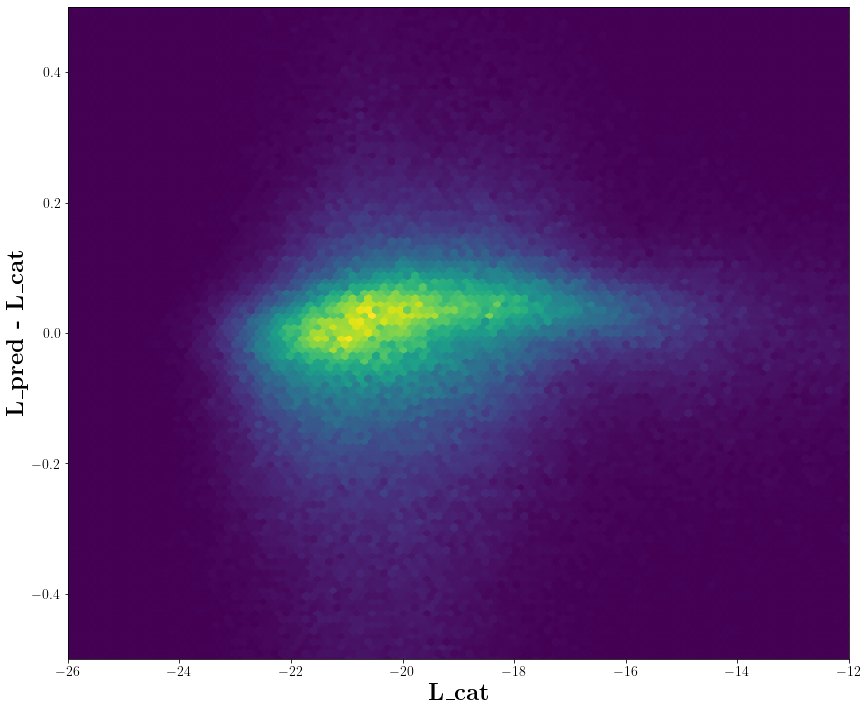

In [24]:
fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(111)
ax.set_xlabel(r'\textbf{L\_cat}', fontsize=24)
ax.set_ylabel(r'\textbf{L\_pred - L\_cat}', fontsize=24)
ax.hexbin(cat['lp_MR'], cat['lp_MR']-r_lum, extent=(-26,-12,-0.5,0.5))
#ax.plot(cat['lp_MR'], cat['lp_MR']-r_lum, '.', alpha=0.04)
ax.set_xlim([-26,-12])
ax.set_ylim([-0.5,0.5])
plt.show()

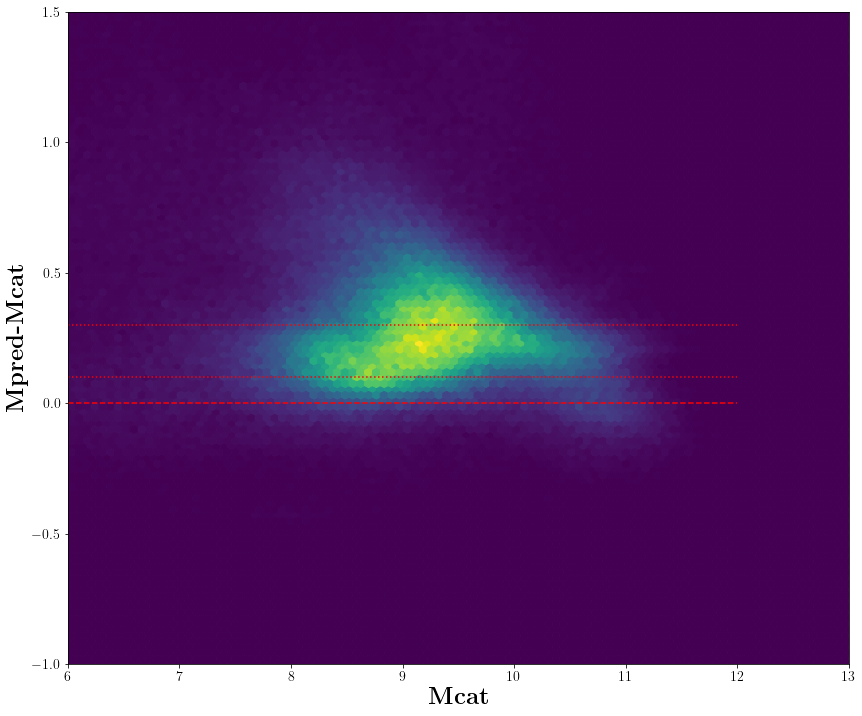

In [25]:
fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(111)
ax.set_xlabel(r'\textbf{Mcat}', fontsize=24)
ax.set_ylabel(r'\textbf{Mpred-Mcat}', fontsize=24)
#ax.set_xscale('log')

#ax.scatter(cat['lp_mass_best'], mass+zscl+offset-cat['lp_mass_best'], marker='.', alpha=0.01)
ax.hexbin(cat['lp_mass_best'], mass+zscl+offset-cat['lp_mass_best'], extent=(6,13,-1,1.5))
ax.plot([6,12],[0,0],'--', c='r')
ax.plot([6,12],[0.3,0.3],':', c='r')
ax.plot([6,12],[0.1,0.1],':', c='r')
# ax.errorbar(W21_lam, W21_phot[ob,:]/W21_lam, yerr=W21_err[ob,:]/W21_lam, marker='o', c='r', 
#             label='W21 SE/LP', capthick=2, capsize=5, ls='', alpha=0.7)

# ax.plot(kcorr_wave[wave_mask]*(1+cat['photoz'][ob]), 
#         sed[wave_mask]*a/(kcorr_wave[wave_mask]*(1+cat['photoz'][ob])), 
#         'k-', alpha=0.7, label='k-correct fit')

ax.set_xlim([6.,13.])
ax.set_ylim([-1.,1.5])
#ax.legend(fontsize=14, loc=2)
plt.show()


#### This is the range of under-estimation mentioned in W21, sec. 6.

21958


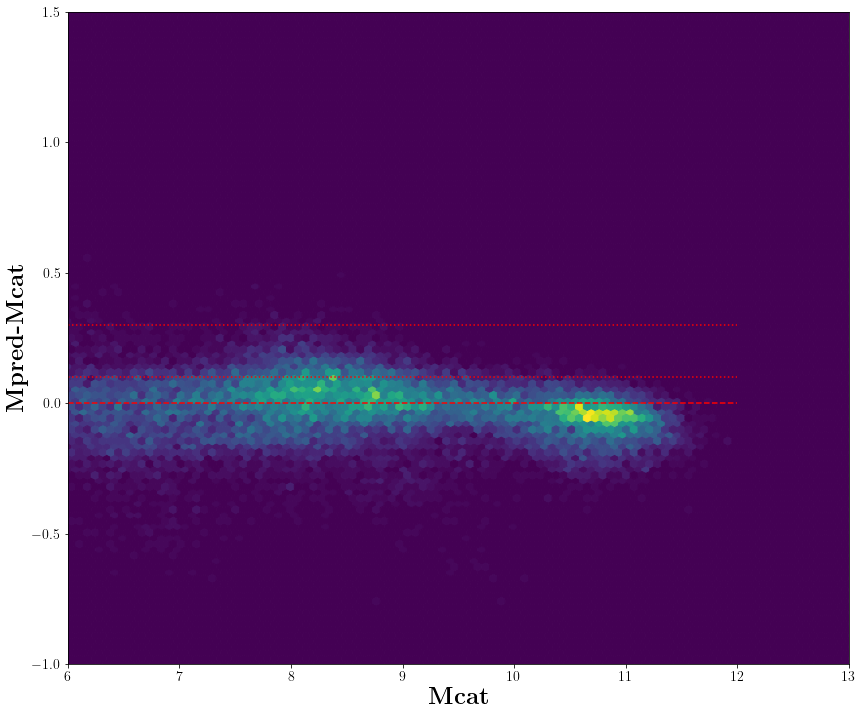

In [26]:
fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(111)
ax.set_xlabel(r'\textbf{Mcat}', fontsize=24)
ax.set_ylabel(r'\textbf{Mpred-Mcat}', fontsize=24)
#ax.set_xscale('log')

p = np.where(cat['lp_age']>5e9)[0]
print(len(p))
#ax.scatter(cat['lp_mass_best'], mass+zscl+offset-cat['lp_mass_best'], marker='.', alpha=0.01)
ax.hexbin(cat['lp_mass_best'][p], (mass+zscl+offset-cat['lp_mass_best'])[p], extent=(6,13,-1,1.5))
ax.plot([6,12],[0,0],'--', c='r')
ax.plot([6,12],[0.3,0.3],':', c='r')
ax.plot([6,12],[0.1,0.1],':', c='r')
# ax.errorbar(W21_lam, W21_phot[ob,:]/W21_lam, yerr=W21_err[ob,:]/W21_lam, marker='o', c='r', 
#             label='W21 SE/LP', capthick=2, capsize=5, ls='', alpha=0.7)

# ax.plot(kcorr_wave[wave_mask]*(1+cat['photoz'][ob]), 
#         sed[wave_mask]*a/(kcorr_wave[wave_mask]*(1+cat['photoz'][ob])), 
#         'k-', alpha=0.7, label='k-correct fit')

ax.set_xlim([6.,13.])
ax.set_ylim([-1.,1.5])
#ax.legend(fontsize=14, loc=2)
plt.show()

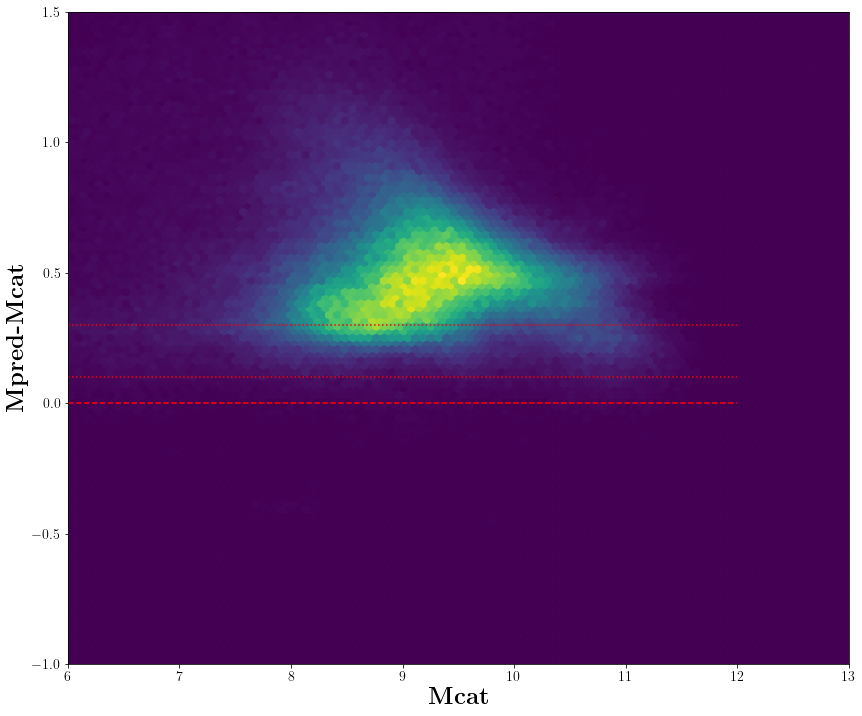

In [27]:
fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(111)
ax.set_xlabel(r'\textbf{Mcat}', fontsize=24)
ax.set_ylabel(r'\textbf{Mpred-Mcat}', fontsize=24)
#ax.set_xscale('log')

#ax.scatter(cat['lp_mass_best'], mass+zscl+offset-cat['lp_mass_best'], marker='.', alpha=0.01)
ax.hexbin(cat['lp_mass_best'], mass_form+zscl+offset-cat['lp_mass_best'], extent=(6,13,-1,1.5))
ax.plot([6,12],[0,0],'--', c='r')
ax.plot([6,12],[0.3,0.3],':', c='r')
ax.plot([6,12],[0.1,0.1],':', c='r')
# ax.errorbar(W21_lam, W21_phot[ob,:]/W21_lam, yerr=W21_err[ob,:]/W21_lam, marker='o', c='r', 
#             label='W21 SE/LP', capthick=2, capsize=5, ls='', alpha=0.7)

# ax.plot(kcorr_wave[wave_mask]*(1+cat['photoz'][ob]), 
#         sed[wave_mask]*a/(kcorr_wave[wave_mask]*(1+cat['photoz'][ob])), 
#         'k-', alpha=0.7, label='k-correct fit')

ax.set_xlim([6.,13.])
ax.set_ylim([-1.,1.5])
#ax.legend(fontsize=14, loc=2)
plt.show()

<ipython-input-28-f58c66d70f7f>:8: RuntimeWarning: invalid value encountered in subtract
  ax.hexbin(cat['lp_mass_best'], mass_form-mass, extent=(6,13,-0.2,0.8))


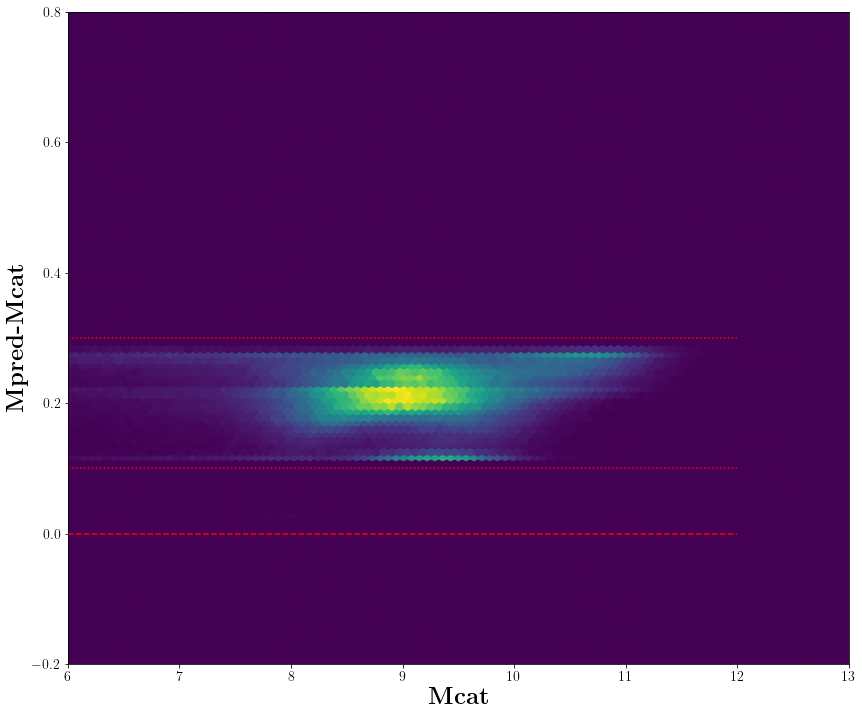

In [28]:
fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(111)
ax.set_xlabel(r'\textbf{Mcat}', fontsize=24)
ax.set_ylabel(r'\textbf{Mpred-Mcat}', fontsize=24)
#ax.set_xscale('log')

#ax.scatter(cat['lp_mass_best'], mass+zscl+offset-cat['lp_mass_best'], marker='.', alpha=0.01)
ax.hexbin(cat['lp_mass_best'], mass_form-mass, extent=(6,13,-0.2,0.8))
ax.plot([6,12],[0,0],'--', c='r')
ax.plot([6,12],[0.3,0.3],':', c='r')
ax.plot([6,12],[0.1,0.1],':', c='r')
# ax.errorbar(W21_lam, W21_phot[ob,:]/W21_lam, yerr=W21_err[ob,:]/W21_lam, marker='o', c='r', 
#             label='W21 SE/LP', capthick=2, capsize=5, ls='', alpha=0.7)

# ax.plot(kcorr_wave[wave_mask]*(1+cat['photoz'][ob]), 
#         sed[wave_mask]*a/(kcorr_wave[wave_mask]*(1+cat['photoz'][ob])), 
#         'k-', alpha=0.7, label='k-correct fit')

ax.set_xlim([6.,13.])
ax.set_ylim([-0.2,0.8])
#ax.legend(fontsize=14, loc=2)
plt.show()

<ipython-input-29-8d4cf3bd001f>:8: RuntimeWarning: invalid value encountered in subtract
  ax.hexbin(cat['lp_mass_best'][p], (mass_form-mass)[p], extent=(6,13,-0.2,0.8))


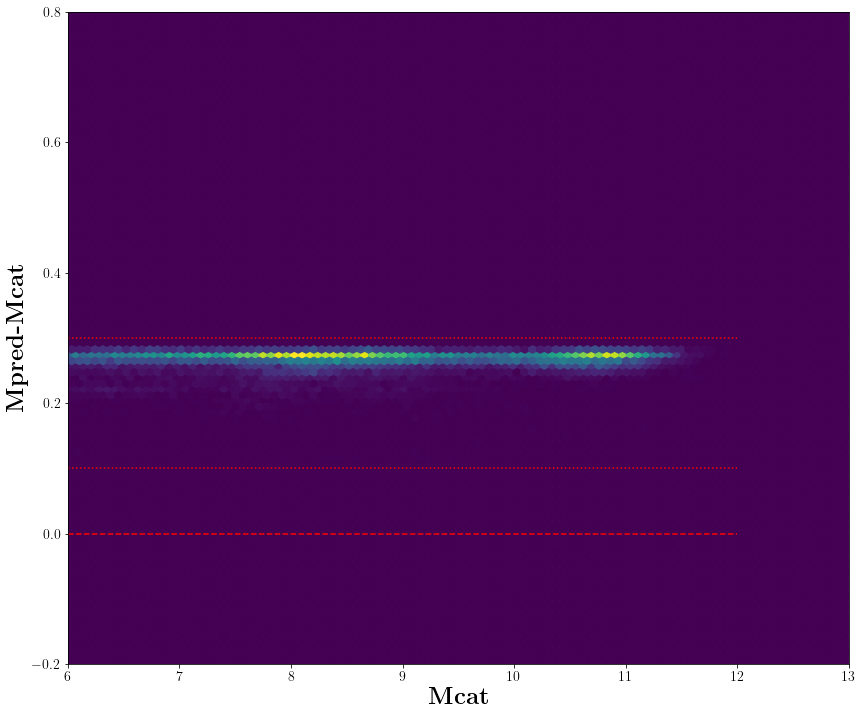

In [29]:
fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(111)
ax.set_xlabel(r'\textbf{Mcat}', fontsize=24)
ax.set_ylabel(r'\textbf{Mpred-Mcat}', fontsize=24)
#ax.set_xscale('log')

#ax.scatter(cat['lp_mass_best'], mass+zscl+offset-cat['lp_mass_best'], marker='.', alpha=0.01)
ax.hexbin(cat['lp_mass_best'][p], (mass_form-mass)[p], extent=(6,13,-0.2,0.8))
ax.plot([6,12],[0,0],'--', c='r')
ax.plot([6,12],[0.3,0.3],':', c='r')
ax.plot([6,12],[0.1,0.1],':', c='r')
# ax.errorbar(W21_lam, W21_phot[ob,:]/W21_lam, yerr=W21_err[ob,:]/W21_lam, marker='o', c='r', 
#             label='W21 SE/LP', capthick=2, capsize=5, ls='', alpha=0.7)

# ax.plot(kcorr_wave[wave_mask]*(1+cat['photoz'][ob]), 
#         sed[wave_mask]*a/(kcorr_wave[wave_mask]*(1+cat['photoz'][ob])), 
#         'k-', alpha=0.7, label='k-correct fit')

ax.set_xlim([6.,13.])
ax.set_ylim([-0.2,0.8])
#ax.legend(fontsize=14, loc=2)
plt.show()

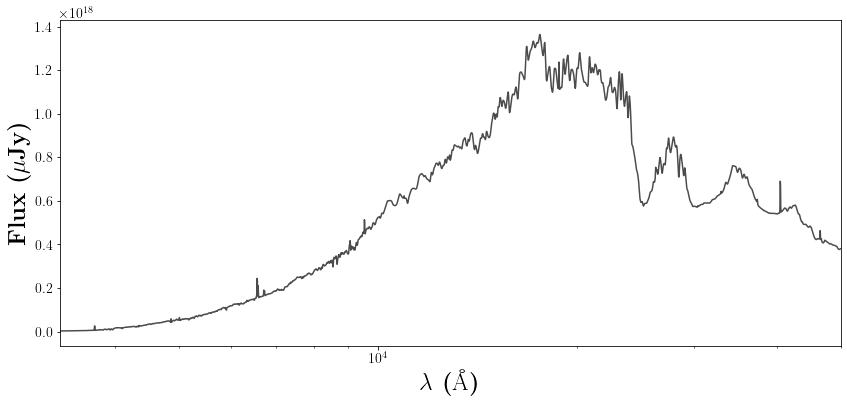

In [30]:
# take one component. What is the SED, uJy, of a galaxy with 1e10 Msun?
sed_tmp = seds[0,:]*1e10
wave_mask = np.where((kcorr_wave>3300)&(kcorr_wave<50000))[0]

# convert to uJy (already done earlier)

# plot
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r'\textbf{$\lambda$ (${\rm \AA}$)}', fontsize=24)
ax.set_ylabel(r'\textbf{Flux ($\mu$Jy)}', fontsize=24)
ax.set_xscale('log')

ax.plot(kcorr_wave[wave_mask], sed_tmp[wave_mask], 'k-', alpha=0.7, label='k-correct fit')

ax.set_xlim([3300.,50000.])
#ax.legend(fontsize=14, loc=2)
plt.show()

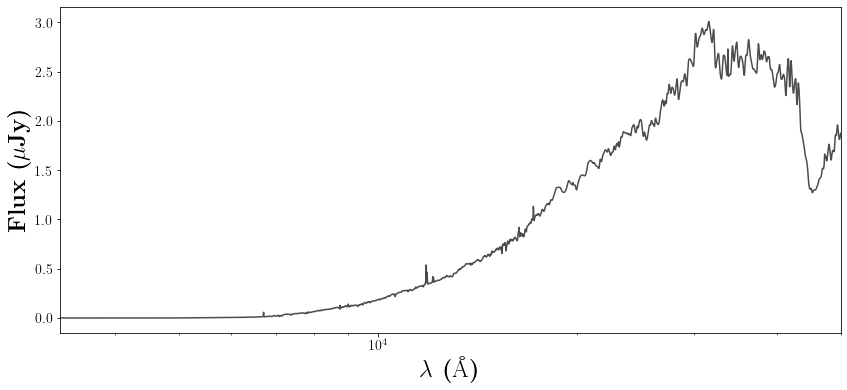

In [31]:
# ok. Now move it to z=0.8
z_tmp = 0.8
sed_tmp /= ((1+z_tmp)*(cosmo.luminosity_distance(z_tmp).value*1e5)**2) 

wave_mask = np.where((kcorr_wave*(1+z_tmp)>3300)&(kcorr_wave*(1+z_tmp)<50000))[0]

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r'\textbf{$\lambda$ (${\rm \AA}$)}', fontsize=24)
ax.set_ylabel(r'\textbf{Flux ($\mu$Jy)}', fontsize=24)
ax.set_xscale('log')
ax.plot((1+z_tmp)*kcorr_wave[wave_mask], sed_tmp[wave_mask], 'k-', alpha=0.7, label='k-correct fit')
ax.set_xlim([3300.,50000.])
plt.show()

In [32]:
# re-open W21 file as a table and add the new mass column
# from astropy.table import Table

# t = Table.read("COSMOS2020_Classic_processed.fits")
# t = t[mask]
# t['kcorr_mass'] = mass+zscl+offset
# t['kcorr_mass_formed'] = mass_form+zscl+offset
# t['R_lum'] = r_lum
# t.write("COSMOS2020_Classic_kcorr_mass_mformed.fits", overwrite=True)

### 

In [33]:
print(stop_here)

NameError: name 'stop_here' is not defined

In [ ]:
from gal_pop import utils, io, lumin_fn, photometry
config = {'SED_dir': "templates/kcorrect", 
          'SED_list': "kcorr_sed_list.txt",
         'wave_grid': [100, 25000, 1],
         'coeff_file': "kcorr_templ_coeffs.npz",}

wave = np.arange(config['wave_grid'][0], config['wave_grid'][1], config['wave_grid'][2])

In [ ]:
cat = pyfits.open("../cosmos_maglim_sample.fits")[1].data

In [ ]:
# gather the template coefficient sets, and associated redshift and luminosity.
eazy_res = np.load(config['coeff_file'])
coeffs = eazy_res['coeffs']
z_cos = eazy_res['z']
lum_cos = eazy_res['lumn']

SB = np.where((cat['PHOTOZ']>2.5))[0]
print(SB[:10], len(SB))

low_z = np.where((cat['PHOTOZ']<0.4)&(23.9-2.5*np.log10(cat['Flux_ip'])<23.))[0]
print(len(low_z))

In [ ]:
bands = ['u', 'B', 'V', 'R', 'ip', 'zpp', 'Y', 'J', 'H', 'Ks']

eff_lam = np.array([3823.3, 4458.3, 5477.8, 6288.7, 7683.9, 9105.7, 10214.2, 12534.6, 16453.4, 21539.9])

filt_files = ['u_cfht.res','B_Subaru.res','V_Subaru.res','r_Subaru.res','i_Subaru.res',
               'suprime_FDCCD_z.res', 'Y_uv.res', 'J_uv.res', 'H_uv.res', 'K_uv.res']
flux = np.array([cat['Flux_'+band]/(eff_lam[i]*eff_lam[i]) for i,band in enumerate(bands)])
ferr = np.array([cat['Fluxerr_'+band]/(eff_lam[i]*eff_lam[i]) for i,band in enumerate(bands)])
print(flux.shape)

In [ ]:
seds = io.read_sed_set(config)
filters = read_filters(filt_files, wave, '../../COSMOS2015_filters/')

In [ ]:
# Get the medium bands to compare too.
Mbands = ['IB427', 'IB464', 'IA484', 'IB505', 'IA527', 'IB574', 'IA624', 'IA679', 'IB709', 'IA738', 
          'IA767', 'IB827']
mb_lam = np.array([4263.4, 4635.1, 4849.2, 5062.5, 5261.1, 5764.8, 6233.1, 6781.1, 7073.6, 7361.6, 7684.9, 
          8244.5])
ib_filters = ['IA427.SuprimeCam.pb', 'IA464.SuprimeCam.pb', 'IA484.SuprimeCam.pb', 'IA505.SuprimeCam.pb', 
              'IA527.SuprimeCam.pb', 'IA574.SuprimeCam.pb', 'IA624.SuprimeCam.pb', 'IA679.SuprimeCam.pb', 
              'IA709.SuprimeCam.pb', 'IA738.SuprimeCam.pb', 'IA767.SuprimeCam.pb', 'IA827.SuprimeCam.pb']

mb_flux = np.array([cat['Flux_'+band]/(mb_lam[i]*mb_lam[i]) for i,band in enumerate(Mbands)])
mb_ferr = np.array([cat['Fluxerr_'+band]/(mb_lam[i]*mb_lam[i]) for i,band in enumerate(Mbands)])


In [ ]:
#indx = SB[2200]
indx = low_z[550]
#sed = np.average(seds, weights=coeffs[:,indx], axis=0)
sed = np.sum(seds.T*coeffs[:,indx], axis=1)
print(cat['PHOTOZ'][indx], coeffs[:,indx])

chi2, a, _, modf = chisq(filters, wave, sed, flux[:,indx], ferr[:,indx], z=cat['PHOTOZ'][indx])
print(chi2)

fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)
ax.set_xlabel(r"\textbf{$\lambda$}", fontsize=24)
ax.set_ylabel(r'\textbf{f$_{\lambda}$}', fontsize=24)
ax.set_xlim([1000.,25000.])
#ax.set_ylim([-0.25,0.25])
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.xaxis.set_ticks(np.array([3000, 5000, 10000, 50000]),('3,000', '5,000', '10,000', '50,000'))

#ax.errorbar(eff_lam, flux[:,ob]*(c*1.e-19/(eff_lam*eff_lam)), yerr=ferr[:,ob]*(c*1.e-19/(eff_lam*eff_lam)),
#            fmt='o', capsize=6)

ax.plot(wave*(1+cat['PHOTOZ'][indx]), sed*a, linewidth=0.5, label='fit SED')
ax.plot(eff_lam, modf*a, 'ko', label='Model photometry')
ax.plot(eff_lam, flux[:,indx], 'ro', label='L15 photometry')
ax.errorbar(eff_lam, flux[:,indx], yerr=ferr[:,indx], color='r', fmt='.')

ax.plot(mb_lam, mb_flux[:,indx], 'go', label='MB photometry')
ax.errorbar(mb_lam, mb_flux[:,indx], yerr=mb_ferr[:,indx], color='g', fmt='.')

ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r"\textbf{$\lambda$}", fontsize=24)
ax.set_ylabel(r'\textbf{f$_{\lambda}$}', fontsize=24)
ax.set_xlim([1000.,25000.])
ax.plot(wave*(1+cat['PHOTOZ'][indx]), sed*a, label='fit SED')
ax.plot(eff_lam, modf*a, 'ko', label='Model photometry')
ax.plot(eff_lam, flux[:,indx], 'ro', label='L15 photometry')
ax.errorbar(eff_lam, flux[:,indx], yerr=ferr[:,indx], color='r', fmt='.')
for i in range(5):
    ax.plot(wave*(1+cat['PHOTOZ'][indx]), seds[i]*a*coeffs[i,indx], '--', 
            label='SED component', c='lightgray')

ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
comp = 0
print(coeffs[comp,indx])
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r"\textbf{$\lambda$}", fontsize=24)
ax.set_ylabel(r'\textbf{f$_{\lambda}$}', fontsize=24)
ax.set_xlim([1000.,25000.])
#ax.plot(wave*(1+cat['PHOTOZ'][indx]), sed*a, label='fit SED')
ax.plot(eff_lam, modf*a, 'ko', label='Model photometry')
ax.plot(eff_lam, flux[:,indx], 'ro', label='L15 photometry')
ax.errorbar(eff_lam, flux[:,indx], yerr=ferr[:,indx], color='r', fmt='.')
ax.plot(wave*(1+cat['PHOTOZ'][indx]), seds[comp]*a*coeffs[comp,indx], '--', 
            label='SED component', c='lightgray')

ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
comp = 1
print(coeffs[comp,indx])
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r"\textbf{$\lambda$}", fontsize=24)
ax.set_ylabel(r'\textbf{f$_{\lambda}$}', fontsize=24)
ax.set_xlim([1000.,25000.])
#ax.plot(wave*(1+cat['PHOTOZ'][indx]), sed*a, label='fit SED')
ax.plot(eff_lam, modf*a, 'ko', label='Model photometry')
ax.plot(eff_lam, flux[:,indx], 'ro', label='L15 photometry')
ax.errorbar(eff_lam, flux[:,indx], yerr=ferr[:,indx], color='r', fmt='.')
ax.plot(wave*(1+cat['PHOTOZ'][indx]), seds[comp]*a*coeffs[comp,indx], '--', 
            label='SED component', c='lightgray')

ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
comp = 2
print(coeffs[comp,indx])
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r"\textbf{$\lambda$}", fontsize=24)
ax.set_ylabel(r'\textbf{f$_{\lambda}$}', fontsize=24)
ax.set_xlim([1000.,25000.])
#ax.plot(wave*(1+cat['PHOTOZ'][indx]), sed*a, label='fit SED')
ax.plot(eff_lam, modf*a, 'ko', label='Model photometry')
ax.plot(eff_lam, flux[:,indx], 'ro', label='L15 photometry')
ax.errorbar(eff_lam, flux[:,indx], yerr=ferr[:,indx], color='r', fmt='.')
ax.plot(wave*(1+cat['PHOTOZ'][indx]), seds[comp]*a*coeffs[comp,indx], '--', 
            label='SED component', c='lightgray')

ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
comp = 3
print(coeffs[comp,indx])
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r"\textbf{$\lambda$}", fontsize=24)
ax.set_ylabel(r'\textbf{f$_{\lambda}$}', fontsize=24)
ax.set_xlim([1000.,25000.])
#ax.plot(wave*(1+cat['PHOTOZ'][indx]), sed*a, label='fit SED')
ax.plot(eff_lam, modf*a, 'ko', label='Model photometry')
ax.plot(eff_lam, flux[:,indx], 'ro', label='L15 photometry')
ax.errorbar(eff_lam, flux[:,indx], yerr=ferr[:,indx], color='r', fmt='.')
ax.plot(wave*(1+cat['PHOTOZ'][indx]), seds[comp]*a*coeffs[comp,indx], '--', 
            label='SED component', c='lightgray')

ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
comp = 4
print(coeffs[comp,indx])
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r"\textbf{$\lambda$}", fontsize=24)
ax.set_ylabel(r'\textbf{f$_{\lambda}$}', fontsize=24)
ax.set_xlim([1000.,25000.])
#ax.plot(wave*(1+cat['PHOTOZ'][indx]), sed*a, label='fit SED')
ax.plot(eff_lam, modf*a, 'ko', label='Model photometry')
ax.plot(eff_lam, flux[:,indx], 'ro', label='L15 photometry')
ax.errorbar(eff_lam, flux[:,indx], yerr=ferr[:,indx], color='r', fmt='.')
ax.plot(wave*(1+cat['PHOTOZ'][indx]), seds[comp]*a*coeffs[comp,indx], '--', 
            label='SED component', c='lightgray')

ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
comp = 2
print(coeffs[comp,indx])
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r"\textbf{$\lambda$}", fontsize=24)
ax.set_ylabel(r'\textbf{f$_{\lambda}$}', fontsize=24)
ax.set_xlim([1000.,25000.])
#ax.plot(wave*(1+cat['PHOTOZ'][indx]), sed*a, label='fit SED')
ax.plot(eff_lam, modf*a, 'ko', label='Model photometry')
ax.plot(eff_lam, flux[:,indx], 'ro', label='L15 photometry')
ax.errorbar(eff_lam, flux[:,indx], yerr=ferr[:,indx], color='r', fmt='.')
ax.plot(wave*(1+cat['PHOTOZ'][indx]), seds[comp]*a*coeffs[comp,indx]*6, '--', 
            label='SED component', c='lightgray')

ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r"\textbf{$\lambda$}", fontsize=24)
ax.set_ylabel(r'\textbf{f$_{\lambda}$}', fontsize=24)
ax.set_xlim([1000.,25000.])
for comp in range(5):
    ax.plot(wave, seds[comp], '-', c='lightgray')
ax.set_yscale('log')
#ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
sed_check = pyfits.open("k_nmf_derived.default_fromskypy.fits")[1].data
wave_check = pyfits.open("k_nmf_derived.default_fromskypy.fits")[11].data

In [ ]:
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r"\textbf{$\lambda$}", fontsize=24)
ax.set_ylabel(r'\textbf{f$_{\lambda}$}', fontsize=24)
ax.set_xlim([1000.,25000.])
for comp in range(5):
    ax.plot(wave_check, sed_check[comp], '-', c='lightgray')
ax.set_yscale('log')
#ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
kcorr = pyfits.open("k_nmf_derived.default_fromskypy.fits")

In [ ]:
kcorr[16].data

In [ ]:
kcorr[17].data

In [ ]:
kcorr[1].data
